In [6]:
# calculate APPL's value for each day with Bellman formula.
from pandas_datareader import data as pdr
import yfinance as yfin
import numpy as np
import utils
import torch
import pandas as pd
yfin.pdr_override()
from utils import load_id_and_macrodata, save_pickle, load_pickle, DNN, remove_nan, get_table_by_id_yahoo, get_table_by_id_fred


In [7]:
# Define the DNN model  

import optuna  
import numpy as np  
import torch  
import torch.nn as nn  
future_period = 128

class DNN(nn.Module):  
    def __init__(self, dim_features, hidden_units, dropout_rate):  
        super(DNN, self).__init__()  
        layers = []  
        input_dim = dim_features  
        for units in hidden_units:  
            layers.append(nn.Linear(input_dim, units))  
            layers.append(nn.Tanh())  # Using Tanh activation function 
            layers.append(nn.Dropout(dropout_rate))
            input_dim = units  
        layers.append(nn.Linear(hidden_units[-1], 1))  # Output layer
        self.model = nn.Sequential(*layers)  
  
    def forward(self, x):  
        return self.model(x)  

In [8]:
# Load the entire model
import glob
from utils import load_pickle, save_pickle
ann_models = []
for i in range(5):
#for index, file_name in enumerate(glob.glob('model/*ANN_optuna*.pkl')):
  file_name = f'model/GSPC_ANN_optuna_{i}.pkl'
  
  ann_model = load_pickle(file_name)
  ann_models.append(ann_model)




In [9]:


#scaler = load_pickle('model/scaler.pkl')
#ml_model = load_pickle(f'model/ml_GSPC_rf_optuna_future_{future_period}.pkl')
scaler = load_pickle('model/scaler240305.pkl')
ml_model = load_pickle(f'model/ml_GSPC_rf_optuna_240305.pkl')

In [10]:
ml_model[1].rf.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.16316225e-05, 4.42107642e-05,
       8.10408821e-05, 0.00000000e+00, 9.30882231e-04, 0.00000000e+00,
       2.26076299e-02, 0.00000000e+00, 5.74570495e-02, 4.69594791e-02,
       7.73927405e-05, 6.46779607e-02, 1.64664160e-04, 3.40684419e-03,
       2.38589978e-02, 9.57561862e-03, 2.74678674e-02, 6.00879737e-02,
       6.17264485e-02, 1.55661366e-01, 1.01159421e-03, 2.29927900e-03,
       1.18955913e-02, 1.15160547e-01, 3.10679823e-02, 9.86368680e-02,
       4.37809357e-03, 2.78169604e-03, 1.23972675e-02, 5.77614138e-02,
       8.73202235e-02, 4.04323858e-02])

In [11]:
ml_model[0].get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [16]:
import os
from utils import add_target, merge_fred
start = '2010-01-01'
end = None


df, column_names = get_table_by_id_yahoo('^GSPC', 10, open=False, start=start, end=end)
df, target_name = add_target(df, '^GSPC', future_period=future_period)

df = df[column_names + [target_name]].copy()

df = merge_fred(df, 'M2SL', 7, start, end, 4, 2, if_log=True)
df = merge_fred(df, 'UNRATE', 6, start, end, 1, 5, if_log=False)
# df_X = merge_fred(df_X, 'GDP', 4, 3, start, end, if_log=True)

df = merge_fred(df, 'FEDFUNDS', 6, start, end, 1, 5, if_log=False)
df = df.dropna()
df_X = df.drop(columns=['LAST_METRIC_DATE', target_name]).copy()

df_y = df[[target_name]].copy()
  
len(df_X.columns)


[*********************100%%**********************]  1 of 1 completed
start: 2010-01-01 end: None
last update for M2SL 2024-01-01 00:00:00 20781.8
start: 2010-01-01 end: None
last update for UNRATE 2024-01-01 00:00:00 3.7
start: 2010-01-01 end: None
last update for FEDFUNDS 2024-02-01 00:00:00 5.33


39

In [17]:
filtered = [item for item, use in zip(df_X.columns.tolist(), ml_model[0].get_support()) if use]
print(filtered)
print(len(filtered))

['log_adj_close_diff_^GSPC_1', 'log_volume_diff_^GSPC_1', 'log_adj_close_diff_^GSPC_2', 'log_volume_diff_^GSPC_2', 'log_adj_close_diff_^GSPC_4', 'log_volume_diff_^GSPC_4', 'log_adj_close_diff_^GSPC_8', 'log_volume_diff_^GSPC_8', 'log_adj_close_diff_^GSPC_16', 'log_volume_diff_^GSPC_16', 'log_adj_close_diff_^GSPC_32', 'log_volume_diff_^GSPC_32', 'log_adj_close_diff_^GSPC_64', 'log_volume_diff_^GSPC_64', 'log_adj_close_diff_^GSPC_128', 'log_adj_close_diff_^GSPC_256', 'log_volume_diff_^GSPC_256', 'log_adj_close_diff_^GSPC_512', 'log_volume_diff_^GSPC_512', 'log_M2SL_diff_1', 'log_M2SL_diff_2', 'log_M2SL_diff_4', 'log_M2SL_diff_8', 'log_M2SL_diff_16', 'log_M2SL_diff_32', 'log_M2SL_diff_64', 'UNRATE_diff_1', 'UNRATE_diff_2', 'UNRATE_diff_4', 'UNRATE_diff_8', 'UNRATE_diff_16', 'UNRATE_diff_32', 'FEDFUNDS_diff_1', 'FEDFUNDS_diff_2', 'FEDFUNDS_diff_4', 'FEDFUNDS_diff_8', 'FEDFUNDS_diff_16', 'FEDFUNDS_diff_32']
38


In [18]:
for name, importance in zip(filtered, ml_model[1].rf.feature_importances_):
  print(name, importance)

log_adj_close_diff_^GSPC_1 0.0
log_volume_diff_^GSPC_1 0.0
log_adj_close_diff_^GSPC_2 0.0
log_volume_diff_^GSPC_2 0.0
log_adj_close_diff_^GSPC_4 0.0
log_volume_diff_^GSPC_4 0.0
log_adj_close_diff_^GSPC_8 7.163162251042767e-05
log_volume_diff_^GSPC_8 4.421076423616777e-05
log_adj_close_diff_^GSPC_16 8.104088206051954e-05
log_volume_diff_^GSPC_16 0.0
log_adj_close_diff_^GSPC_32 0.0009308822309783215
log_volume_diff_^GSPC_32 0.0
log_adj_close_diff_^GSPC_64 0.022607629936024946
log_volume_diff_^GSPC_64 0.0
log_adj_close_diff_^GSPC_128 0.057457049534068314
log_adj_close_diff_^GSPC_256 0.046959479072129634
log_volume_diff_^GSPC_256 7.739274047475486e-05
log_adj_close_diff_^GSPC_512 0.06467796072272855
log_volume_diff_^GSPC_512 0.00016466416019024146
log_M2SL_diff_1 0.003406844187016111
log_M2SL_diff_2 0.02385899776583196
log_M2SL_diff_4 0.009575618617695
log_M2SL_diff_8 0.027467867421266685
log_M2SL_diff_16 0.06008797373920531
log_M2SL_diff_32 0.061726448543055944
log_M2SL_diff_64 0.15566136

In [19]:
# Compute SHAP values to determine the direction of the impact
import shap
rf = ml_model[1].rf
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(df_X)


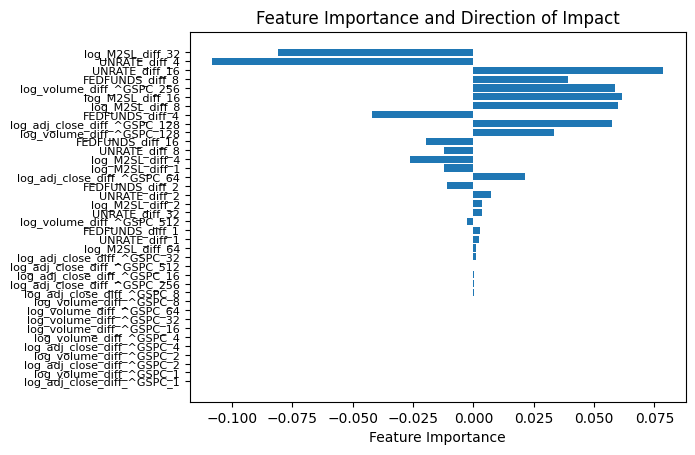

In [20]:
import matplotlib.pyplot as plt

feature_importances = rf.feature_importances_
# Calculate the mean absolute SHAP values for each feature
shap_sum = np.abs(shap_values).mean(axis=0)

# Determine the sign of the SHAP values
shap_sign = np.sign(shap_values).mean(axis=0)

# Plotting feature importances with their impact direction
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importances[sorted_idx] * shap_sign[sorted_idx], align='center')
plt.yticks(pos, np.array(df_X.columns)[sorted_idx], fontsize=8)
plt.xlabel('Feature Importance')
plt.title('Feature Importance and Direction of Impact')
plt.show()

In [21]:

# price_columns = [col for col in df_X.columns if 'close' in col]
# volume_columns = [col for col in df_X.columns if 'volume' in col]
# df_X = df_X[price_columns+volume_columns]


df_y = df_y.fillna(0)



In [22]:
df_X.columns

Index(['log_adj_close_diff_^GSPC_1', 'log_volume_diff_^GSPC_1',
       'log_adj_close_diff_^GSPC_2', 'log_volume_diff_^GSPC_2',
       'log_adj_close_diff_^GSPC_4', 'log_volume_diff_^GSPC_4',
       'log_adj_close_diff_^GSPC_8', 'log_volume_diff_^GSPC_8',
       'log_adj_close_diff_^GSPC_16', 'log_volume_diff_^GSPC_16',
       'log_adj_close_diff_^GSPC_32', 'log_volume_diff_^GSPC_32',
       'log_adj_close_diff_^GSPC_64', 'log_volume_diff_^GSPC_64',
       'log_adj_close_diff_^GSPC_128', 'log_volume_diff_^GSPC_128',
       'log_adj_close_diff_^GSPC_256', 'log_volume_diff_^GSPC_256',
       'log_adj_close_diff_^GSPC_512', 'log_volume_diff_^GSPC_512',
       'log_M2SL_diff_1', 'log_M2SL_diff_2', 'log_M2SL_diff_4',
       'log_M2SL_diff_8', 'log_M2SL_diff_16', 'log_M2SL_diff_32',
       'log_M2SL_diff_64', 'UNRATE_diff_1', 'UNRATE_diff_2', 'UNRATE_diff_4',
       'UNRATE_diff_8', 'UNRATE_diff_16', 'UNRATE_diff_32', 'FEDFUNDS_diff_1',
       'FEDFUNDS_diff_2', 'FEDFUNDS_diff_4', 'FEDFUNDS_

In [23]:
print(df_X.shape)
print(df_y.shape)

(3529, 39)
(3529, 1)


In [24]:
X_test = scaler.transform(df_X)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [25]:
def predict_with_std(pipeline, test_X):
    """
    Given a trained pipeline with a random forest regressor as the final step,
    returns the mean and standard deviation of the predictions.

    Parameters:
        pipeline: The trained pipeline with preprocessing steps and a random forest regressor.
        test_X: The test input features.

    Returns:
        mean_predictions: The mean of all the trees' predictions.
        std_predictions: The standard deviation of all the trees' predictions.
    """
    
    # Apply preprocessing steps on the test data
    for name, step in pipeline.steps[:-1]:
        test_X = step.transform(test_X)
        
    # Extract the random forest model from the last step of the pipeline
    model = pipeline.named_steps['regress']
    
    # Get the predictions from each tree
    all_predictions = np.array([tree.predict(test_X) for tree in model.rf.estimators_])
    
    # Calculate mean and standard deviation of predictions for each sample
    mean_predictions = np.mean(all_predictions, axis=0)
    std_predictions = np.std(all_predictions, axis=0)
    lower_quartile = np.percentile(all_predictions, 25, axis=0)
    upper_quartile = np.percentile(all_predictions, 75, axis=0)
    
    return mean_predictions, std_predictions, lower_quartile, upper_quartile

def predict_with_std_ann(models, X_test_tensor):
    """
    Given a trained pipeline with a random forest regressor as the final step,
    returns the mean and standard deviation of the predictions.

    Parameters:
        pipeline: The trained pipeline with preprocessing steps and a random forest regressor.
        test_X: The test input features.

    Returns:
        mean_predictions: The mean of all the trees' predictions.
        std_predictions: The standard deviation of all the trees' predictions.
    """
    
    # Apply preprocessing steps on the test data
    all_predictions = []
    for index, model in enumerate(models):
      model.eval().cpu()
      test_X = model(X_test_tensor)
      if index == 0:
        all_predictions = test_X.detach().numpy()
      else:
        all_predictions = np.concatenate((all_predictions, test_X.detach().numpy()), axis=1)
    # Calculate mean and standard deviation of predictions for each sample
    mean_predictions = np.mean(all_predictions, axis=1)
    std_predictions = np.std(all_predictions, axis=1)
    lower_quartile = np.percentile(all_predictions, 25, axis=1)
    upper_quartile = np.percentile(all_predictions, 75, axis=1)
    return mean_predictions, std_predictions, lower_quartile, upper_quartile
  
y_pred_ann, y_pred_std_ann, lower_quartile_ann, upper_quartile_ann = predict_with_std_ann(ann_models, X_test_tensor)
print(y_pred_ann.shape)
print(y_pred_std_ann.shape)

(3529,)
(3529,)


In [26]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

y_pred, y_pred_std, lower_quartile, upper_quartile = predict_with_std(ml_model, X_test)
y_pred_ann, y_pred_std_ann, lower_quartile_ann, upper_quartile_ann = predict_with_std_ann(ann_models, X_test_tensor)

window_size = 10


df['GSPC_pred_ml'] = y_pred
df['GSPC_pred_ml'] = df['GSPC_pred_ml'].rolling(window_size).mean()
df['GSPC_test'] = df_y.values
df['GSPC_pred_ann'] = y_pred_ann
df['GSPC_pred_ann'] = df['GSPC_pred_ann'].rolling(window_size).mean()

pd.options.plotting.backend = "plotly"

# Calculate upper and lower bounds based on standard deviation
df['GSPC_pred_lower_quartile'] = lower_quartile
df['GSPC_pred_upper_quartile'] = upper_quartile

df['GSPC_pred_lower_quartile_ann'] = lower_quartile_ann
df['GSPC_pred_upper_quartile_ann'] = upper_quartile_ann


# Create subplots
fig = make_subplots(rows=2, cols=1, row_heights=[0.6, 0.4])
# Add traces to the subplots

fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_pred_upper_quartile'], name='GSPC_pred_upper_quartile', 
                         line=dict(width=0)), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_pred_lower_quartile'], name='GSPC_pred_lower_quartile', line=dict(width=0), 
                         fill='tonexty', fillcolor='rgba(0,100,80,0.2)'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_pred_ml'], name='GSPC_pred_ml'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_test'], name='GSPC_test'), row=1, col=1)


fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_pred_upper_quartile_ann'], name='GSPC_pred_upper_quartile_ann', 
                         line=dict(width=0)), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_pred_lower_quartile_ann'], name='GSPC_pred_lower_quartile_ann', line=dict(width=0), 
                         fill='tonexty', fillcolor='rgba(255,165,0,0.5)'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_pred_ann'], name='GSPC_pred_ann'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=np.exp(df['log_adj_close_^GSPC']), name='Adj Close'), row=2, col=1)

# Update layout and display the plot
fig.update_layout(height=600, width=800, 
                  title_text="GSPC 128d predict", 
                  xaxis=dict(
                    tickformat="%Y-%m-%d",
                    dtick="M12"
                  ))

fig.update_xaxes(
    tickformat="%Y-%m-%d",
    dtick="M6",
    row=1,
    col=1
)

fig.update_xaxes(
    tickformat="%Y-%m-%d",
    dtick="M6",
    matches='x', # This line links the x-axis of the second subplot to that of the first subplot
    row=2,
    col=1
)

fig.show()

X does not have valid feature names, but SelectKBest was fitted with feature names


ValueError: Input X contains NaN.
SelectKBest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [102]:
y_pred

array([-0.07463897, -0.07463897, -0.07463897, ...,  0.11764675,
        0.11764675,  0.11764675])

In [18]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

y_pred, y_pred_std,lower_quartile, upper_quartile = predict_with_std(ml_model, X_test_tensor)

df['GSPC_pred_ml'] = y_pred
df['GSPC_test'] = df_y.values


pd.options.plotting.backend = "plotly"
# Create subplots
fig = make_subplots(rows=2, cols=1, row_heights=[0.6, 0.4])
# Add traces to the subplots

fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_pred_ml'], name='GSPC_pred_ml'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_test'], name='GSPC_test'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=np.exp(df['log_adj_close_^GSPC']), name='adj_close'), row=2, col=1)

# Update layout and display the plot
fig.update_layout(height=600, width=800, 
                  title_text="GSPC 1y predict", 
                  xaxis=dict(
                    tickformat="%Y-%m-%d",
                    dtick="M12"
                  ))

fig.update_xaxes(
    tickformat="%Y-%m-%d",
    dtick="M6",
    row=1,
    col=1
)

fig.update_xaxes(
    tickformat="%Y-%m-%d",
    dtick="M6",
    matches='x', # This line links the x-axis of the second subplot to that of the first subplot
    row=2,
    col=1
)

fig.show()

/home/ken/anaconda3/envs/stock/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but SelectKBest was fitted with feature names

/tmp/ipykernel_6650/3793665423.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_6650/3793665423.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots



df['GSPC_pred_ml'] = y_pred
df['GSPC_test'] = df_y.values


pd.options.plotting.backend = "plotly"
# Create subplots
fig = make_subplots(rows=2, cols=1, row_heights=[0.6, 0.4])
# Add traces to the subplots
fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_pred_ml'], name='GSPC_pred_ml'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['GSPC_test'], name='GSPC_test'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=np.exp(df['log_adj_close_^GSPC']), name='adj_close'), row=2, col=1)

# Update layout and display the plot
fig.update_layout(height=600, width=800, 
                  title_text="GSPC 1y predict", 
                  xaxis=dict(
                    tickformat="%Y-%m-%d",
                    dtick="M12"
                  ))

fig.update_xaxes(
    tickformat="%Y-%m-%d",
    dtick="M6",
    row=1,
    col=1
)

fig.update_xaxes(
    tickformat="%Y-%m-%d",
    dtick="M6",
    matches='x', # This line links the x-axis of the second subplot to that of the first subplot
    row=2,
    col=1
)

fig.show()

NameError: name 'outputs' is not defined

In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,log_adj_close_^GSPC,last_log_adj_close_^GSPC,log_volume_^GSPC,log_adj_close_diff_^GSPC_1,...,log_adj_close_diff_^GSPC_128,log_volume_diff_^GSPC_128,log_adj_close_diff_^GSPC_256,log_volume_diff_^GSPC_256,log_adj_close_diff_^GSPC_512,log_volume_diff_^GSPC_512,future_profit_^GSPC_256,target_bell,GSPC_pred,GSPC_test
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-14 00:00:00-04:00,4366.290039,4391.819824,4337.850098,4372.589844,4372.589844,4252110000,8.383111,8.382292,22.170681,0.000819,...,0.098225,0.059397,0.049677,0.000918,0.038339,-0.316231,NaN,NaN,0.216464,0.0
2023-06-15 00:00:00-04:00,4365.330078,4439.200195,4362.600098,4425.839844,4425.839844,4176690000,8.395215,8.383111,22.152785,0.012105,...,0.117707,0.071557,0.072634,0.004131,0.054079,-0.291097,NaN,NaN,0.211912,0.0
2023-06-16 00:00:00-04:00,4440.950195,4448.470215,4407.439941,4409.589844,4409.589844,6848600000,8.391537,8.395215,22.647310,-0.003678,...,0.099850,0.562009,0.093042,0.504758,0.041606,0.503399,NaN,NaN,0.199062,0.0
2023-06-20 00:00:00-04:00,4396.109863,4400.149902,4367.189941,4388.709961,4388.709961,4055790000,8.386791,8.391537,22.123411,-0.004746,...,0.087841,-0.225040,0.117838,-0.186973,0.037656,-0.098790,NaN,NaN,0.211784,0.0
2023-06-21 00:00:00-04:00,4380.009766,4386.220215,4360.140137,4365.689941,4365.689941,2324030000,8.381532,8.386791,21.566569,-0.005259,...,0.088653,-0.654609,0.152119,-0.886030,0.032222,-0.695631,NaN,NaN,0.236991,0.0


In [9]:
df, columns = get_table_by_id_yahoo('AAPL',10)

[*********************100%***********************]  1 of 1 completed


In [16]:
tmp = df['log_adj_close_diff_AAPL_1']
df['target'] = 0
for i in range(256):
  tmp = tmp.shift(-1)
  df['target'] = df['target'] + (0.99**i) * tmp
  
  

In [18]:
df['target_name_1y'] = df['log_adj_close_AAPL'].shift(-256) - df['log_adj_close_AAPL']

<AxesSubplot:xlabel='Date'>

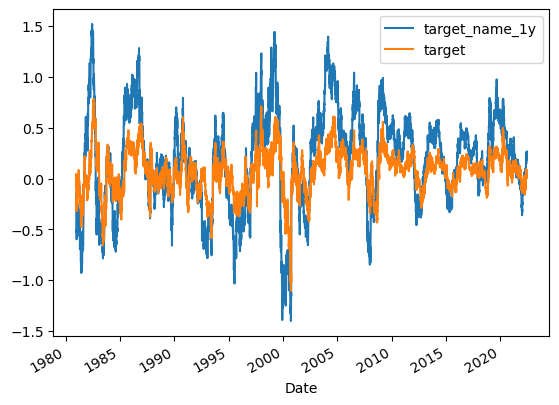

In [19]:
df[['target_name_1y', 'target']].plot()

In [ ]:
df['log_adj_close_next_2'] = 0.99 * df['log_adj_close_next_2'].shift(-1)